<a href="https://colab.research.google.com/github/larzryan/keras-complex/blob/main/image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2023/11/09<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2025-07-27 19:52:34.286504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 19:52:34.294547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753660354.303695   46563 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753660354.306612   46563 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753660354.313747   46563 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  64.6M      0  0:00:12  0:00:12 --:--:-- 64.1M


In [ ]:
!unzip -oq kagglecatsanddogs_5340.zip
!ls

 anaconda3		      save_at_11.keras	 save_at_24.keras
 CDLA-Permissive-2.0.pdf      save_at_12.keras	 save_at_25.keras
 Desktop		      save_at_13.keras	 save_at_2.keras
 Documents		      save_at_14.keras	 save_at_3.keras
 Downloads		      save_at_15.keras	 save_at_4.keras
 environment.yml	      save_at_16.keras	 save_at_5.keras
 hTorch.yml		      save_at_17.keras	 save_at_6.keras
 kagglecatsanddogs_5340.zip   save_at_18.keras	 save_at_7.keras
 Music			      save_at_19.keras	 save_at_8.keras
 PetImages		      save_at_1.keras	 save_at_9.keras
 Pictures		      save_at_20.keras	 snap
 Public			      save_at_21.keras	 startJuypter.sh
'readme[1].txt'		      save_at_22.keras	 Templates
 save_at_10.keras	      save_at_23.keras	 Videos


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
subfolder contains image files for each category.

In [ ]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## Generate a `Dataset`

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


I0000 00:00:1753660594.041852   46563 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


## Visualize the data

Here are the first 9 images in the training dataset.

2025-07-27 19:56:39.082709: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


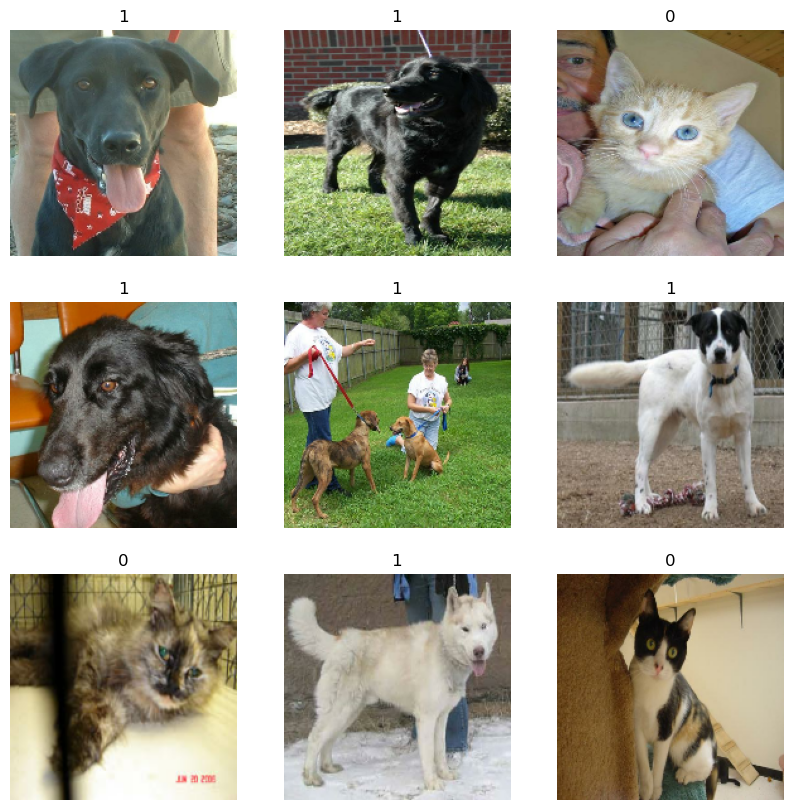

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

2025-07-27 19:56:46.368037: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


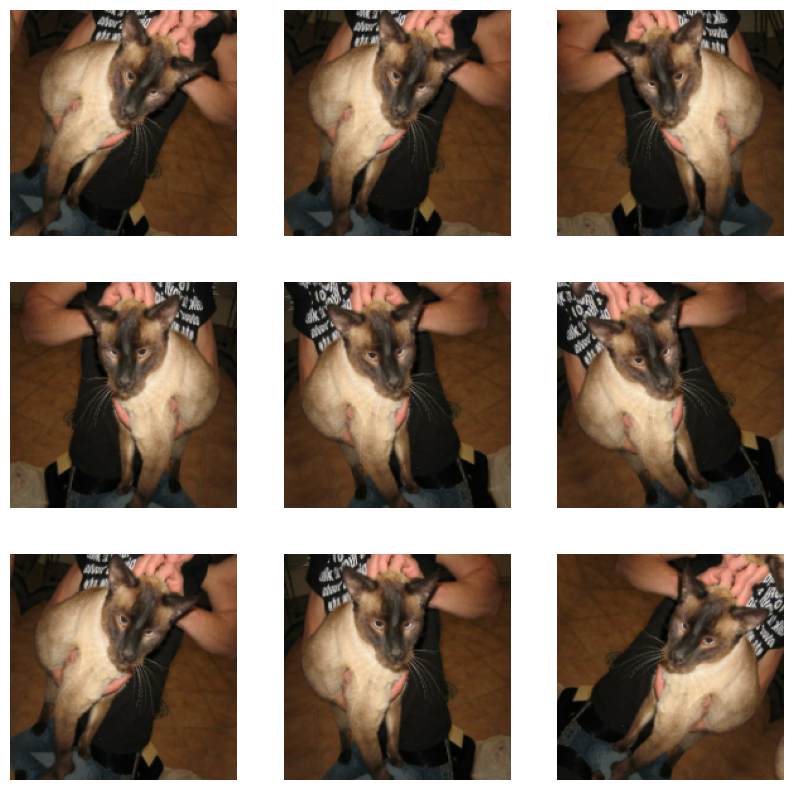

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

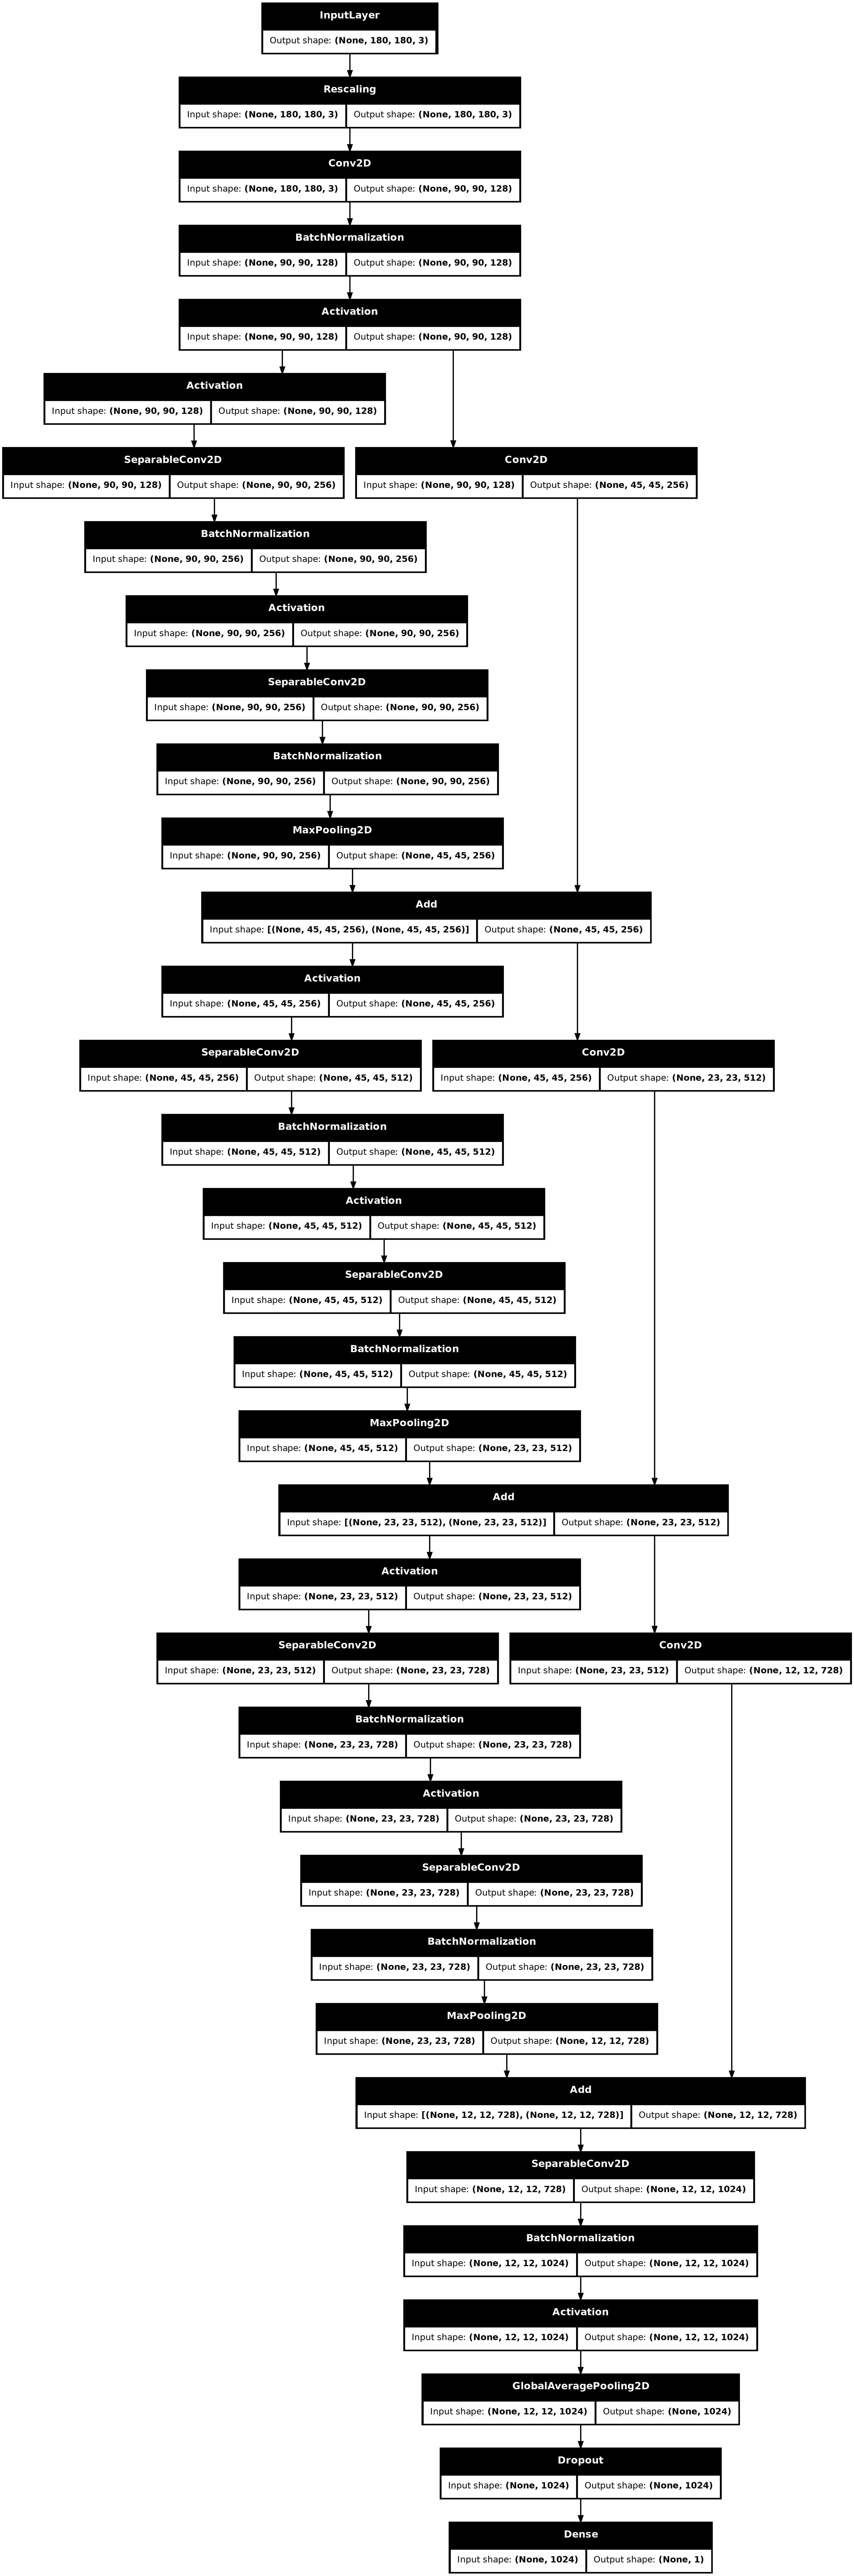

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
I0000 00:00:1753660633.155010   46889 service.cc:152] XLA service 0x3a9ea000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753660633.155031   46889 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-07-27 19:57:13.475277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753660633.943616   46889 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-27 19:57:28.653786: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1753660658.759785   46889 device_compiler.h:188

 45/147 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - acc: 0.5970 - loss: 0.6693

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 53/147 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - acc: 0.6010 - loss: 0.6645

 73/147 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - acc: 0.6093 - loss: 0.6552

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 77/147 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - acc: 0.6108 - loss: 0.6535

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - acc: 0.6186 - loss: 0.6453

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - acc: 0.6332 - loss: 0.6304

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 348ms/step - acc: 0.6334 - loss: 0.6302 - val_acc: 0.4957 - val_loss: 0.6986
Epoch 2/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/147 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - acc: 0.7510 - loss: 0.5015

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 49/147 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - acc: 0.7511 - loss: 0.5011

 69/147 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - acc: 0.7521 - loss: 0.4959

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 71/147 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - acc: 0.7522 - loss: 0.4954

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.7525 - loss: 0.4943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - acc: 0.7599 - loss: 0.4802

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 257ms/step - acc: 0.7599 - loss: 0.4800 - val_acc: 0.4957 - val_loss: 0.6943
Epoch 3/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/147 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - acc: 0.8011 - loss: 0.4063

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 71/147 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - acc: 0.8051 - loss: 0.4014

 79/147 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - acc: 0.8062 - loss: 0.3998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 80/147 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - acc: 0.8063 - loss: 0.3996

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/147 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - acc: 0.8068 - loss: 0.3988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/147 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - acc: 0.8079 - loss: 0.3973

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - acc: 0.8134 - loss: 0.3894

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 260ms/step - acc: 0.8135 - loss: 0.3893 - val_acc: 0.4957 - val_loss: 0.6923
Epoch 4/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 38/147 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - acc: 0.8533 - loss: 0.3327

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 48/147 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - acc: 0.8530 - loss: 0.3316

 69/147 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - acc: 0.8529 - loss: 0.3293

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - acc: 0.8530 - loss: 0.3290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 73/147 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - acc: 0.8530 - loss: 0.3289

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - acc: 0.8551 - loss: 0.3207

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - acc: 0.8551 - loss: 0.3206 - val_acc: 0.4957 - val_loss: 0.8939
Epoch 5/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 41/147 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - acc: 0.8763 - loss: 0.2874

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 70/147 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - acc: 0.8783 - loss: 0.2797

 71/147 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - acc: 0.8783 - loss: 0.2795

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/147 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - acc: 0.8785 - loss: 0.2787

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 77/147 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - acc: 0.8786 - loss: 0.2784

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 82/147 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - acc: 0.8788 - loss: 0.2777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - acc: 0.8796 - loss: 0.2728

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - acc: 0.8796 - loss: 0.2728 - val_acc: 0.7777 - val_loss: 0.3771
Epoch 6/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 43/147 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - acc: 0.8915 - loss: 0.2538

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 55/147 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - acc: 0.8914 - loss: 0.2524

 77/147 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - acc: 0.8920 - loss: 0.2495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 79/147 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - acc: 0.8921 - loss: 0.2492

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/147 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - acc: 0.8924 - loss: 0.2482

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/147 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - acc: 0.8925 - loss: 0.2479

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - acc: 0.8951 - loss: 0.2413

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 243ms/step - acc: 0.8951 - loss: 0.2412 - val_acc: 0.8977 - val_loss: 0.2791
Epoch 7/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/147 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - acc: 0.9113 - loss: 0.2029

 50/147 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - acc: 0.9112 - loss: 0.2031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 65/147 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - acc: 0.9110 - loss: 0.2037

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 69/147 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - acc: 0.9110 - loss: 0.2037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 72/147 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - acc: 0.9110 - loss: 0.2037

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/147 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - acc: 0.9110 - loss: 0.2040

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - acc: 0.9108 - loss: 0.2048

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - acc: 0.9108 - loss: 0.2047 - val_acc: 0.8738 - val_loss: 0.2574
Epoch 8/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 41/147 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - acc: 0.9103 - loss: 0.2043

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 64/147 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - acc: 0.9113 - loss: 0.2012

 77/147 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - acc: 0.9119 - loss: 0.1995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 78/147 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - acc: 0.9119 - loss: 0.1994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/147 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - acc: 0.9120 - loss: 0.1993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 80/147 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - acc: 0.9120 - loss: 0.1991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - acc: 0.9143 - loss: 0.1939

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 246ms/step - acc: 0.9144 - loss: 0.1938 - val_acc: 0.9274 - val_loss: 0.1809
Epoch 9/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 41/147 ━━━━━━━━━━━━━━━━━━━━ 25s 241ms/step - acc: 0.9196 - loss: 0.1840

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 49/147 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - acc: 0.9203 - loss: 0.1831

 69/147 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - acc: 0.9210 - loss: 0.1816

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 74/147 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.9212 - loss: 0.1811

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/147 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.9213 - loss: 0.1810

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/147 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.9213 - loss: 0.1809

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


132/147 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - acc: 0.9239 - loss: 0.1760

KeyboardInterrupt: 

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img_path = "PetImages/Cat/6779.jpg"

try:
    img = keras.utils.load_img(img_path, target_size=image_size)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

except AttributeError as e:
    print(f"Could not load image {img_path} due to error: {e}")
except Exception as e:
    print(f"An unexpected error occurred while processing {img_path}: {e}")

In [ ]:
! ls PetImages/Cat/677*.jpg

PetImages/Cat/6771.jpg	PetImages/Cat/6775.jpg	PetImages/Cat/6779.jpg
PetImages/Cat/6772.jpg	PetImages/Cat/6776.jpg	PetImages/Cat/677.jpg
PetImages/Cat/6773.jpg	PetImages/Cat/6777.jpg
PetImages/Cat/6774.jpg	PetImages/Cat/6778.jpg
